In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
import torch

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
df = pd.read_csv('train.csv')  # Replace with your actual file path

# Data Cleaning
df = df.dropna(subset=['text'])  # Remove rows with missing values in the 'text' column
df = df.drop_duplicates()  # Remove duplicates

# Data Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\<.*?\>', '', text)  # Remove HTML tags
    text = re.sub(r'\@w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

# Apply preprocessing
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Keep the original cleaned text for later use
X_text = df['cleaned_text'].values  # Save the cleaned text in a separate variable
y = df['target'].values  # Ensure 'target' column is also clean

# Check if there are any NaN values in the target column
if np.any(pd.isna(y)):
    raise ValueError("Target column contains NaN values. Please clean your dataset.")

# Prepare the dataset
X = df['cleaned_text'].values


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()  # Use mean of the last hidden states

# Generate BERT embeddings for the cleaned text
X_embeddings = np.array([get_bert_embeddings(text) for text in X])

# Step 3: Split the data for training and testing
X_train, X_test, y_train, y_test, X_train_text, X_test_text = train_test_split(
    X_embeddings, y, X_text, test_size=0.3, random_state=42
)

# Step 4: Keyword extraction function
def extract_keywords(text):
    # Split the text into individual words
    return text.split()  # Return the list of words as keywords

# Example of extracting keywords from the training and test sets using the keyword extraction method
X_train_keywords = []  # Initialize an empty list to hold keywords for training instances
X_test_keywords = []   # Initialize an empty list to hold keywords for test instances

# Extract keywords for training set
for text in X_train_text:
    keywords = extract_keywords(text)  # Call the keyword extraction function
    X_train_keywords.append(keywords)

# Extract keywords for test set
for text in X_test_text:
    keywords = extract_keywords(text)  # Call the keyword extraction function
    X_test_keywords.append(keywords)

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the training set:")
for i in range(min(5, len(X_train_text))):  # Safeguard against fewer than 5 instances
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_train_text[i]}")  # Print the original cleaned text from the training set
    print(f"Extracted Keywords: {X_train_keywords[i]}")  # Print extracted keywords

print("\nSample extracted keywords from the test set:")
for i in range(min(5, len(X_test_text))):  # Safeguard against fewer than 5 instances
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Print the original cleaned text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Print extracted keywords

print("Shape of BERT embeddings:", X_embeddings.shape)
print("Total samples:", len(X_embeddings))
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))
print("Training labels:", len(y_train))
print("Testing labels:", len(y_test))
print("Training text:", len(X_train_text))
print("Testing text:", len(X_test_text))



Sample extracted keywords from the training set:

Sentence 1:
Original Text: rengoku set heart ablaze p missed style coloring c
Extracted Keywords: ['rengoku', 'set', 'heart', 'ablaze', 'p', 'missed', 'style', 'coloring', 'c']

Sentence 2:
Original Text: time prepare future show invest multifamily apartment building order
Extracted Keywords: ['time', 'prepare', 'future', 'show', 'invest', 'multifamily', 'apartment', 'building', 'order']

Sentence 3:
Original Text: published new blog entry man pulled burning car meet one hero saved wsfa pinna
Extracted Keywords: ['published', 'new', 'blog', 'entry', 'man', 'pulled', 'burning', 'car', 'meet', 'one', 'hero', 'saved', 'wsfa', 'pinna']

Sentence 4:
Original Text: every single year im drowning tear im drowning tear
Extracted Keywords: ['every', 'single', 'year', 'im', 'drowning', 'tear', 'im', 'drowning', 'tear']

Sentence 5:
Original Text: wondering timeline group lesbian violently
Extracted Keywords: ['wondering', 'timeline', 'group', 'le

In [3]:

import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for Decision Tree with additional tuning options
param_grid_dt = {
    'max_depth': [None, 10, 20, 30, 50],  # Increasing depth for more complexity
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 5, 10],    # Minimum number of samples to be at a leaf node
    'criterion': ['gini', 'entropy'],     # Try both 'gini' and 'entropy'
    'class_weight': ['balanced', None],   # Try balancing class weights
    'max_leaf_nodes': [None, 10, 20, 50], # Limit the number of leaves to prevent overfitting
    'min_impurity_decrease': [0.0, 0.01, 0.1],  # Set the minimum impurity decrease for pruning
}

# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_dt = RandomizedSearchCV(
    dt_model, param_distributions=param_grid_dt,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_dt.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for Decision Tree: ", random_search_dt.best_params_)

# Get the best model from RandomizedSearchCV
best_dt_model = random_search_dt.best_estimator_

# Predict and evaluate on the test set
y_test_pred_dt = best_dt_model.predict(X_test)  # Replace X_test with your test set embeddings
print("Decision Tree Performance on Test Set:\n", classification_report(y_test, y_test_pred_dt))

# Calculate and print test accuracy
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f"Test Accuracy with Decision Tree: {test_accuracy_dt:.4f}")

# Save the trained Decision Tree model to a file using joblib
model_filename_dt = 'decision_tree_model_with_smote.pkl'
joblib.dump(best_dt_model, model_filename_dt)
print(f"Trained Decision Tree model saved to {model_filename_dt}")

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for Decision Tree:  {'min_samples_split': 10, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 20, 'max_depth': 10, 'criterion': 'entropy', 'class_weight': None}
Decision Tree Performance on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.79      0.85      2808
           1       0.42      0.72      0.53       603

    accuracy                           0.78      3411
   macro avg       0.68      0.75      0.69      3411
weighted avg       0.84      0.78      0.80      3411

Test Accuracy with Decision Tree: 0.7754
Trained Decision Tree model saved to decision_tree_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: many illegal building demolished city guadalajara enrique alfaro mitigation
Extracted Keywords: ['many', 'illegal', 'building', 'demolished', 'city', '

In [4]:
# -----------------------------------------------------
# MLPClassifier Section
# -----------------------------------------------------
from sklearn.neural_network import MLPClassifier

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for MLPClassifier with additional tuning options
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 100)],  # Vary hidden layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions to try
    'solver': ['adam', 'sgd'],        # Solvers for optimization
    'alpha': [0.0001, 0.001, 0.01],   # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedule
    'learning_rate_init': [0.001, 0.01],        # Initial learning rate
    'max_iter': [200, 300, 500],                # Number of iterations to run
    'batch_size': [64, 128, 256],               # Batch size for training
}

# Initialize the MLPClassifier model
mlp_model = MLPClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_mlp = RandomizedSearchCV(
    mlp_model, param_distributions=param_grid_mlp,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_mlp.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for MLP: ", random_search_mlp.best_params_)

# Get the best model from RandomizedSearchCV
best_mlp_model = random_search_mlp.best_estimator_

# Predict and evaluate on the test set
y_test_pred_mlp = best_mlp_model.predict(X_test)  # Replace X_test with your test set embeddings
print("MLP Performance on Test Set:\n", classification_report(y_test, y_test_pred_mlp))

# Calculate and print test accuracy
test_accuracy_mlp = accuracy_score(y_test, y_test_pred_mlp)
print(f"Test Accuracy with MLP: {test_accuracy_mlp:.4f}")

# Save the trained MLP model to a file using joblib
model_filename_mlp = 'mlp_model_with_smote.pkl'
joblib.dump(best_mlp_model, model_filename_mlp)
print(f"Trained MLP model saved to {model_filename_mlp}")

# -----------------------------------------------------
# Print the extracted keywords for interpretation
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for MLP:  {'solver': 'adam', 'max_iter': 300, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (150,), 'batch_size': 64, 'alpha': 0.0001, 'activation': 'tanh'}
MLP Performance on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2808
           1       0.69      0.68      0.68       603

    accuracy                           0.89      3411
   macro avg       0.81      0.81      0.81      3411
weighted avg       0.89      0.89      0.89      3411

Test Accuracy with MLP: 0.8883
Trained MLP model saved to mlp_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: many illegal building demolished city guadalajara enrique alfaro mitigation
Extracted Keywords: ['many', 'illegal', 'building', 'demolished', 'city', 'guadalajara', 'enrique', 'alfaro'

In [5]:

# -----------------------------------------------------
# SVM Section
# -----------------------------------------------------
from sklearn.svm import SVC

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for SVM with additional tuning options
param_grid_svm = {
    'C': [0.1, 1, 10, 100],                    # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Different kernel types
    'degree': [2, 3, 4],                        # Degree of the polynomial kernel (only relevant for 'poly' kernel)
    'gamma': ['scale', 'auto'],                 # Kernel coefficient
    'class_weight': ['balanced', None],         # Handling class imbalance
    'tol': [1e-3, 1e-4, 1e-5],                   # Tolerance for stopping criterion
}

# Initialize the SVM model
svm_model = SVC(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_svm = RandomizedSearchCV(
    svm_model, param_distributions=param_grid_svm,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_svm.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for SVM: ", random_search_svm.best_params_)

# Get the best model from RandomizedSearchCV
best_svm_model = random_search_svm.best_estimator_

# Predict and evaluate on the test set
y_test_pred_svm = best_svm_model.predict(X_test)  # Replace X_test with your test set embeddings
print("SVM Performance on Test Set:\n", classification_report(y_test, y_test_pred_svm))

# Calculate and print test accuracy
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
print(f"Test Accuracy with SVM: {test_accuracy_svm:.4f}")

# Save the trained SVM model to a file using joblib
model_filename_svm = 'svm_model_with_smote.pkl'
joblib.dump(best_svm_model, model_filename_svm)
print(f"Trained SVM model saved to {model_filename_svm}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for SVM:  {'tol': 0.0001, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'class_weight': None, 'C': 10}
SVM Performance on Test Set:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      2808
           1       0.58      0.75      0.66       603

    accuracy                           0.86      3411
   macro avg       0.76      0.82      0.79      3411
weighted avg       0.88      0.86      0.87      3411

Test Accuracy with SVM: 0.8619
Trained SVM model saved to svm_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: many illegal building demolished city guadalajara enrique alfaro mitigation
Extracted Keywords: ['many', 'illegal', 'building', 'demolished', 'city', 'guadalajara', 'enrique', 'alfaro', 'mitigation']

Sentence 2:
Original Text: who fatality tho
Extracted Keywords: ['who'

In [8]:

# -----------------------------------------------------
# XGBoost Section
# -----------------------------------------------------
from xgboost import XGBClassifier

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],          # Number of trees
    'max_depth': [3, 5, 10],                  # Maximum depth of a tree
    'learning_rate': [0.001, 0.01, 0.1],      # Step size shrinkage to prevent overfitting
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for fitting individual trees
    'colsample_bytree': [0.6, 0.8, 1.0],      # Fraction of features used for tree construction
    'gamma': [0, 0.1, 0.3],                    # Minimum loss reduction for further partitioning
    'reg_lambda': [1, 1.5, 2.0],              # L2 regularization term on weights
    'scale_pos_weight': [1, 3, 5],            # Control class imbalance (higher for imbalance)
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_grid_xgb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for XGBoost: ", random_search_xgb.best_params_)

# Get the best model from RandomizedSearchCV
best_xgb_model = random_search_xgb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_xgb = best_xgb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("XGBoost Performance on Test Set:\n", classification_report(y_test, y_test_pred_xgb))

# Calculate and print test accuracy
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Test Accuracy with XGBoost: {test_accuracy_xgb:.4f}")

# Save the trained XGBoost model to a file using joblib
model_filename_xgb = 'xgboost_model_with_smote.pkl'
joblib.dump(best_xgb_model, model_filename_xgb)
print(f"Trained XGBoost model saved to {model_filename_xgb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


XGBoostLibraryNotFound: Cannot find XGBoost Library in the candidate path, did you install compilers and run build.sh in root path?
List of candidates:
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\xgboost.dll
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\../../lib/xgboost.dll
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\./lib/xgboost.dll
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\xgboost\xgboost.dll
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\../../windows/x64/Release/xgboost.dll
C:\Users\rahul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\./windows/x64/Release/xgboost.dll

In [4]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
# -----------------------------------------------------
# Gradient Boosting Section
# -----------------------------------------------------
from sklearn.ensemble import GradientBoostingClassifier

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 500],          # Number of boosting stages
    'max_depth': [3, 5, 10],                  # Maximum depth of the individual regression estimators
    'learning_rate': [0.001, 0.01, 0.1],      # Learning rate shrinks contribution of each tree
    'subsample': [0.6, 0.8, 1.0],             # Fraction of samples used for fitting the individual base learners
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 5],            # Minimum number of samples required to be a leaf node
    'max_features': ['sqrt', 'log2', None],   # Number of features to consider when looking for the best split
    'min_impurity_decrease': [0.0, 0.01, 0.1],# Minimum impurity decrease for a node split
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_gb = RandomizedSearchCV(
    gb_model, param_distributions=param_grid_gb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_gb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for Gradient Boosting: ", random_search_gb.best_params_)

# Get the best model from RandomizedSearchCV
best_gb_model = random_search_gb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_gb = best_gb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("Gradient Boosting Performance on Test Set:\n", classification_report(y_test, y_test_pred_gb))

# Calculate and print test accuracy
test_accuracy_gb = accuracy_score(y_test, y_test_pred_gb)
print(f"Test Accuracy with Gradient Boosting: {test_accuracy_gb:.4f}")

# Save the trained Gradient Boosting model to a file using joblib
model_filename_gb = 'gradient_boosting_model_with_smote.pkl'
joblib.dump(best_gb_model, model_filename_gb)
print(f"Trained Gradient Boosting model saved to {model_filename_gb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found for Gradient Boosting:  {'subsample': 1.0, 'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
Gradient Boosting Performance on Test Set:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      2808
           1       0.67      0.67      0.67       603

    accuracy                           0.88      3411
   macro avg       0.80      0.80      0.80      3411
weighted avg       0.88      0.88      0.88      3411

Test Accuracy with Gradient Boosting: 0.8845
Trained Gradient Boosting model saved to gradient_boosting_model_with_smote.pkl

Sample extracted keywords from the test set (for the first 5 instances):

Sentence 1:
Original Text: many illegal building demolished city guadalajara enrique alfaro mitigation
Extracted Keywords: ['many', 'illegal', 

In [8]:
# -----------------------------------------------------
# LightGBM Section
# -----------------------------------------------------
import lightgbm as lgb

# Apply SMOTE to oversample the minority class in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)  # Resample with SMOTE

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 500],           # Number of boosting rounds
    'num_leaves': [31, 50, 100],               # Maximum number of leaves in one tree
    'max_depth': [-1, 10, 20, 30],             # Maximum depth of trees
    'learning_rate': [0.001, 0.01, 0.1],       # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],              # Fraction of samples used per iteration
    'colsample_bytree': [0.6, 0.8, 1.0],       # Fraction of features used per iteration
    'min_child_weight': [1, 5, 10],            # Minimum sum of instance weight needed in a child node
    'reg_alpha': [0, 0.1, 1.0],                # L1 regularization term
    'reg_lambda': [0, 0.1, 1.0],               # L2 regularization term
    'scale_pos_weight': [1, 3, 5],             # Weight for balancing positive and negative classes
}

# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Perform RandomizedSearchCV for hyperparameter tuning
random_search_lgb = RandomizedSearchCV(
    lgb_model, param_distributions=param_grid_lgb,
    n_iter=10, cv=3, scoring='f1', verbose=1, n_jobs=-1, random_state=42
)
random_search_lgb.fit(X_train_resampled, y_train_resampled)

# Print the best parameters found by RandomizedSearchCV
print("Best parameters found for LightGBM: ", random_search_lgb.best_params_)

# Get the best model from RandomizedSearchCV
best_lgb_model = random_search_lgb.best_estimator_

# Predict and evaluate on the test set
y_test_pred_lgb = best_lgb_model.predict(X_test)  # Replace X_test with your test set embeddings
print("LightGBM Performance on Test Set:\n", classification_report(y_test, y_test_pred_lgb))

# Calculate and print test accuracy
test_accuracy_lgb = accuracy_score(y_test, y_test_pred_lgb)
print(f"Test Accuracy with LightGBM: {test_accuracy_lgb:.4f}")

# Save the trained LightGBM model to a file using joblib
model_filename_lgb = 'lightgbm_model_with_smote.pkl'
joblib.dump(best_lgb_model, model_filename_lgb)
print(f"Trained LightGBM model saved to {model_filename_lgb}")

# -----------------------------------------------------
# Optional: Print the extracted keywords for interpretation (if applicable)
# -----------------------------------------------------
print("\nSample extracted keywords from the test set (for the first 5 instances):")
for i in range(5):  # Print the first 5 test samples and their extracted keywords
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Original text from the test set
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # Extracted keywords

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 6448, number of negative: 6448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 12896, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best parameters found for LightGBM:  {'subsample': 0.8, 'scale_pos_weight': 3, 'reg_lambda': 0.1, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
LightGBM Performance on Test Set:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      2808
           1       0.65      0.71      0.68       603

    accuracy                           0.88      3411
   m

In [5]:
# -----------------------------------------------------
# SHAP Explanation Section
# -----------------------------------------------------
# %pip install shap
import shap

# Ensure X_test is a NumPy array if it's not already
if isinstance(X_test, tuple):
    X_test = np.array(X_test)

# Sample the background data to reduce computation time (using nsamples, not K)
background_data = shap.sample(X_train_resampled, nsamples=20)  # Sample 20 background samples

# Initialize the SHAP explainer with the best XGBoost model
explainer = shap.KernelExplainer(best_gb_model.predict, background_data)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(np.array(X_test))

# Note: BERT embeddings are high-dimensional and not directly interpretable with keywords.
# The following feature_names setup may not be meaningful as embeddings don't correspond to specific keywords.
# If you have a way to map embeddings back to keywords, you can modify this accordingly.

# Since BERT embeddings are numeric vectors, assigning feature names from keywords isn't directly applicable.
# Instead, you might skip feature names or handle explanations differently.


100%|██████████| 3411/3411 [5:03:02<00:00,  5.33s/it]  


AttributeError: 'list' object has no attribute 'keys'

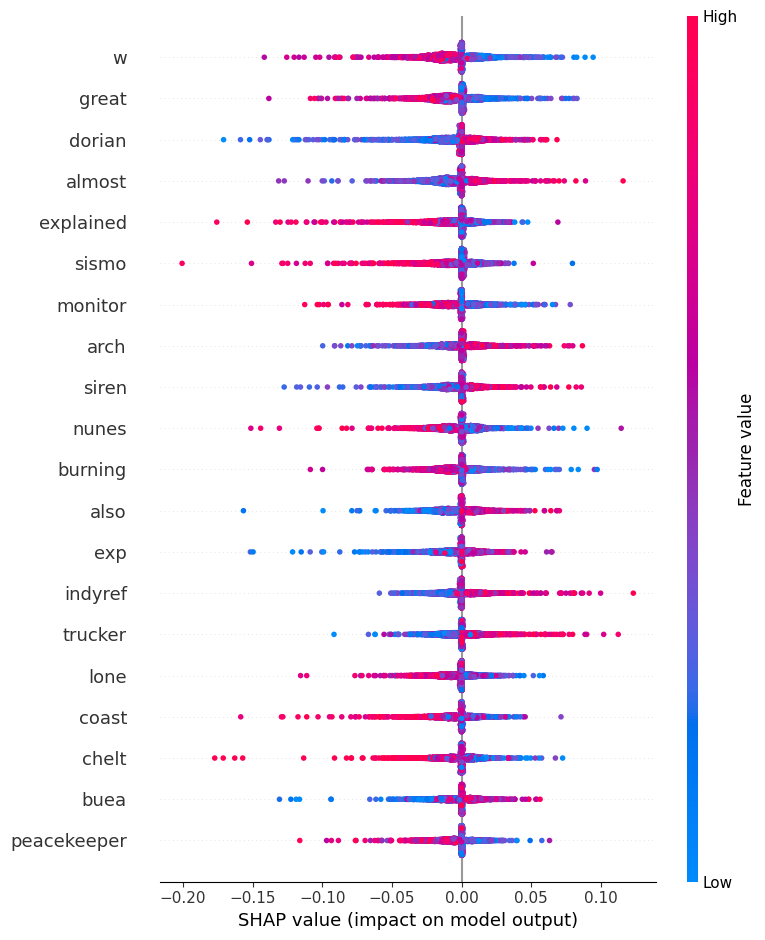


Sample extracted keywords from the test set (for the first 100 instances):

Sentence 1:
Original Text: many illegal building demolished city guadalajara enrique alfaro mitigation
Extracted Keywords: ['many', 'illegal', 'building', 'demolished', 'city', 'guadalajara', 'enrique', 'alfaro', 'mitigation']

Sentence 2:
Original Text: who fatality tho
Extracted Keywords: ['who', 'fatality', 'tho']

Sentence 3:
Original Text: onthisday chinese state medium confirmed iranian tanker sanchi sunk burning wee
Extracted Keywords: ['onthisday', 'chinese', 'state', 'medium', 'confirmed', 'iranian', 'tanker', 'sanchi', 'sunk', 'burning', 'wee']

Sentence 4:
Original Text: luck miss windstorm either sidefly safe xxx
Extracted Keywords: ['luck', 'miss', 'windstorm', 'either', 'sidefly', 'safe', 'xxx']

Sentence 5:
Original Text: inferno black friday death building much fuel lit hand man jonova
Extracted Keywords: ['inferno', 'black', 'friday', 'death', 'building', 'much', 'fuel', 'lit', 'hand', 'man', 

In [7]:
feature_names = []
for keywords in X_test_keywords:
    feature_names.extend(keywords)


# Generate a SHAP summary plot
shap.summary_plot(shap_values, features=np.array(X_test), feature_names=feature_names)  # feature_names set to None

# Print the extracted keywords for interpretation (for the first 100 instances)
print("\nSample extracted keywords from the test set (for the first 100 instances):")
for i in range(min(30, len(X_test))):  # Safeguard against fewer than 100 instances
    print(f"\nSentence {i + 1}:")
    print(f"Original Text: {X_test_text[i]}")  # Replace X_test with original text for BERT inputs
    print(f"Extracted Keywords: {X_test_keywords[i]}")  # No need to call .keys() since it's already a list